# How to trace Machine Learning Techniques?
## C4.5 Decision Tree 

- This code is based in https://github.com/barisesmer/C4.5 
    - It's available at https://github.com/correiajoao/C4.5

### C4.5 class declaration

- Fetch data 
- Pre-processing data
- Split attributes
- Computes info gain
- Build tree
- Print tree
- Classify instances

In [1]:
import sys
import math
import pandas as pd
import numpy as np
import logging
from copy import copy
import matplotlib.pyplot as plt
from IPython.display import display
from graphviz import Digraph, Source

logging.basicConfig(stream=sys.stdout, format='', level=logging.INFO, datefmt=None)

%matplotlib inline

class C45:

	"""Creates a decision tree with C4.5 algorithm"""
	def __init__(self, pathToData,pathToNames):
		self.filePathToData = pathToData
		self.filePathToNames = pathToNames
		self.data = []
		self.classes = []
		self.numAttributes = -1 
		self.attrValues = {}
		self.attributes = []
		self.tree = None

		self.train = []
		self.test = []

		# === Just for log prupose ===
		self.splitCounter = 0
		self.nodeId = 0
		#=============================

		self.graph = Digraph('Decision Tree')
		self.graph.node_attr.update(color='lightblue2', style='filled')

		# === Just for graph generation ===
		self.infoGain = []
		self.threshold = []
		#==================================

	def fetchData(self):
		logging.info("FETCHING ATTRIBUTES SETTINGS ...")

		with open(self.filePathToNames, "r") as file:
			classes = file.readline()
			self.classes = [x.strip() for x in classes.split(",")]

			logging.info("	Classes: {}".format(self.classes))
			logging.info("	Number of classes: {}".format(len(self.classes)))
			
			#add attributes
			for line in file:
				[attribute, values] = [x.strip() for x in line.split(":")]
				values = [x.strip() for x in values.split(",")]
				self.attrValues[attribute] = values
				self.attributes.append(attribute)
			
		self.numAttributes = len(self.attrValues.keys())
		logging.info("	Number of atributes: {}".format(self.numAttributes))
		
		with open(self.filePathToData, "r") as file:
			for line in file:
				row = [x.strip() for x in line.split(",")]
				if row != [] or row != [""]:
					self.data.append(row)

	def preprocessData(self):
		
		# === Just for log prupose ===
		AttrContinuous = []
		AttrDiscrete = []
		#=============================

		logging.info("PRE-PROCESSING DATA ...")

		for index,row in enumerate(self.data):
			for attr_index in range(self.numAttributes):
				if(not self.isAttrDiscrete(self.attributes[attr_index])):
					AttrContinuous.append(self.attributes[attr_index])
					self.data[index][attr_index] = float(self.data[index][attr_index])
				else:
					AttrDiscrete.append(self.attributes[attr_index])
		

		self.test = self.data[0:int(len(self.data)*0.1)]
		self.train = self.data[int(len(self.data)*0.1):int(len(self.data))]		

		for i in self.train:
			logging.info("	Train: {}".format(i));

		for i in self.test:
			logging.info("	Test: {}".format(i));

		
		# === Plotting train and test instances ===
		plt.rcParams['figure.figsize'] = [12, 10]

		train = pd.DataFrame(self.train)
		test = pd.DataFrame(self.test)

		plt.subplot(2, 1, 1)
		plt.title('Train instances')
		plt.ylabel('Values')
		plt.ylim(0,8)
		train.columns=['petal length', 'sepal width', 'sepal length', 'petal width' ,"Outcome"]
		pd.plotting.parallel_coordinates(train, "Outcome")
		
		plt.subplot(2, 1, 2)
		plt.title('Test instances')
		plt.xlabel('Attributes')
		plt.ylabel('Values')
		plt.ylim(0,8)
		test.columns=['petal length', 'sepal width', 'sepal length', 'petal width' ,"Outcome"]
		pd.plotting.parallel_coordinates(test, "Outcome")
		
		plt.show()
		# ========================================


		self.formatInstancesToTest()

		logging.info("	Continuous attributes: {}".format(set(AttrContinuous)));
		logging.info("	Discrete attributes: {}".format(set(AttrDiscrete)));
		
		logging.info("	Data size: {}".format(len(self.data)));
		logging.info("	Train size: {}".format(len(self.train)));
		logging.info("	Test size: {}".format(len(self.test)));
		
	def formatInstancesToTest(self):
		atrAux = copy(self.attributes)
		atrAux.append("outcome")
		self.test = [dict(zip(atrAux, values)) for values in self.test]

	def printTree(self):

		logging.info("")
		logging.info("")
		logging.info("PRINTING TREE ...")
		self.printNode(copy(self.tree))
		logging.info("")
		logging.info("")
		self.drawTree(copy(self.tree), True)
		display(Source(self.graph))
        
		
	def printNode(self, node, indent=""):	
		if not node.isLeaf:
			if node.threshold is None:
				#discrete
				for index,child in enumerate(node.children):
					if child.isLeaf:
						print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " = " + attributes[index] + " : " + child.label + "  ")
					else:
						print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " = " + attributes[index] + " : ")
						self.printNode(child, indent + "	")
			else:
				#numerical
				leftChild = node.children[0]
				rightChild = node.children[1]

				if leftChild.isLeaf:
					self.graph.edge(str(node.identifier), str(leftChild.identifier), label=str(node.label) +' <= ' + str(node.threshold))
					print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " <= " + str(node.threshold) + " : " + leftChild.label + "  ")
				else:
					self.graph.edge(str(node.identifier), str(leftChild.identifier), label=str(node.label) +' <= ' + str(node.threshold))
					print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " <= " + str(node.threshold)+" : ")
					self.printNode(leftChild, indent + "	")

				if rightChild.isLeaf:
					print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " > " + str(node.threshold) + " : " + rightChild.label + "  " )
					self.graph.edge(str(node.identifier), str(rightChild.identifier), label=str(node.label) +' > ' + str(node.threshold))
				else:
					self.graph.edge(str(node.identifier), str(rightChild.identifier), label=str(node.label) +' > ' + str(node.threshold))
					print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " > " + str(node.threshold) + " : ")
					self.printNode(rightChild , indent + "	")

	def drawTree(self, node, first):

		if not node.isLeaf:
			
			if(first == True):
				self.graph.node(str(node.identifier), label=str(node.label))

			if node.threshold is None:
				print("")
				#for index,child in enumerate(node.children):
					#if child.isLeaf:
						#print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " = " + attributes[index] + " : " + child.label + "  ")
					#else:
						#print(indent +"(Node: "+ str(node.identifier) +" - " +"SrcSplit: "+ str(node.sourceSplit) +") " + node.label + " = " + attributes[index] + " : ")
						#self.printNode(child, indent + "	")
			else:
				leftChild = node.children[0]
				rightChild = node.children[1]

				if leftChild.isLeaf:
					self.graph.node(str(leftChild.identifier), label=str(leftChild.label))
					#self.graph.edge(str(node.identifier), str(leftChild.identifier), label=str(node.label) +' <= ' + str(node.threshold))
				else:
					self.graph.node(str(leftChild.identifier), label=str(leftChild.label))
					#self.graph.edge(str(node.identifier), str(leftChild.identifier), label=str(node.label) +' <= ' + str(node.threshold))
					self.drawTree(leftChild,False)

				if rightChild.isLeaf:
					self.graph.node(str(rightChild.identifier), label=str(rightChild.label))
					#self.graph.edge(str(node.identifier), str(rightChild.identifier), label=str(node.label) +' > ' + str(node.threshold))
				else:
					self.graph.node(str(rightChild.identifier), label=str(rightChild.label))
					#self.graph.edge(str(node.identifier), str(rightChild.identifier), label=str(node.label) +' > ' + str(node.threshold))
					self.drawTree(rightChild,False)				

	def generateTree(self):
		logging.info("BUILDING TREE ...");
		self.tree = self.recursiveGenerateTree(self.train, self.attributes)

	def recursiveGenerateTree(self, curData, curAttributes):
		self.nodeId += 1
		logging.info("	Attributes: {}".format(curAttributes))
		logging.info("	Generating node: {}".format(self.nodeId))

		if len(curData) == 0:
			#Fail
			return Node(self.nodeId, True, "Fail", None, None, -1)

		elif len(curAttributes) == 0:
			#return a node with the majority class
			majClass = self.getMajClass(curData)
			return Node(self.nodeId, True, majClass, None, None, -1)

		elif self.allSameClass(curData) is not False:
			#return a node with that class
			logging.info("	No split, all data has the same class: {} ".format(curData[-1]))
			return Node(self.nodeId, True, self.allSameClass(curData), None, None, -1)
		else:

			(best, best_threshold, splitted, maxEnt, sourceSplit) = self.splitAttribute(curData, curAttributes)
			
			logging.info("")
			logging.info(" ---------------------------------------------------------------------------------------------")
			logging.info("	Split id: {}".format(sourceSplit))
			logging.info("	Best attribute: {}".format(best))
			logging.info("	Best thresoulder: {}".format(best_threshold))
			logging.info("	Max gain: {}".format(maxEnt))
			logging.info(" ---------------------------------------------------------------------------------------------")
			logging.info("")
            
			plt.title('Info Gain distribution to Node '+ str(self.nodeId))
			#plt.ylim(0, 1)
			plt.xlabel('Threshold')
			plt.ylabel('Info Gain')
			plt.show()

			remainingAttributes = curAttributes[:]
			remainingAttributes.remove(best)
			node = Node(self.nodeId, False, best, best_threshold, maxEnt, sourceSplit)
			node.children = [self.recursiveGenerateTree(subset, remainingAttributes) for subset in splitted]
			return node

	def getMajClass(self, curData):
		freq = [0]*len(self.classes)
		for row in curData:
			index = self.classes.index(row[-1])
			freq[index] += 1
		maxInd = freq.index(max(freq))
		return self.classes[maxInd]

	def allSameClass(self, data):
		for row in data:
			if row[-1] != data[0][-1]:
				return False
		return data[0][-1]

	def isAttrDiscrete(self, attribute):
		if attribute not in self.attributes:
			raise ValueError("Attribute not listed")
		elif (len(self.attrValues[attribute]) == 1) and (self.attrValues[attribute][0] == "continuous"):
			return False
		else:
			return True

	def splitAttribute(self, curData, curAttributes):
		splitted = []
		splitId = -1
		maxEnt = -1*float("inf")
		best_attribute = -1
		best_threshold = None
		
		for attribute in curAttributes:

			self.splitCounter += 1;
			logging.info("	Split: {} -- Attribute: {}".format(self.splitCounter, attribute))
			
			indexOfAttribute = self.attributes.index(attribute)
			if self.isAttrDiscrete(attribute):
				#split curData into n-subsets, where n is the number of 
				#different values of attribute i. Choose the attribute with
				#the max gain
				valuesForAttribute = self.attrValues[attribute]
				subsets = [[] for a in valuesForAttribute]
				for row in curData:
					for index in range(len(valuesForAttribute)):
						if row == valuesForAttribute[index]:
							subsets[index].append(row)
							break

				e = self.gain(curData, subsets)
				if e > maxEnt:
					maxEnt = e
					splitted = subsets
					best_attribute = attribute
					best_threshold = None
			else:
				#sort the data according to the column.Then try all 
				#possible adjacent pairs. Choose the one that 
				#yields maximum gain
				curData.sort(key = lambda x: x[indexOfAttribute])
				for j in range(0, len(curData) - 1):
					if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
						threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
						less = []
						greater = []
						for row in curData:
							if(row[indexOfAttribute] > threshold):
								greater.append(row)
							else:
								less.append(row)

						e = self.gain(curData, [less, greater])
						logging.info("			Current info gain: {} -- Threshould: {}".format(e, threshold));
						self.infoGain.append(e)
						self.threshold.append(threshold)                      

						if e >= maxEnt:
							splitted = [less, greater]
							splitId = self.splitCounter
							maxEnt = e
							best_attribute = attribute
							best_threshold = threshold
            
            # ============ Plot InfoGain and values splitted to thin attribute ====================               
			plt.rcParams['figure.figsize'] = [10, 7]
			plt.plot(self.threshold, self.infoGain, marker='o', linestyle='dashed', linewidth=2, markersize=7, label=attribute)
			plt.legend()
			self.infoGain = []
			self.threshold = []
			# =====================================================================================

		return (best_attribute,best_threshold,splitted, maxEnt, splitId)

	def gain(self,unionSet, subsets):
		#input : data and disjoint subsets of it
		#output : information gain
		S = len(unionSet)
		#calculate impurity before split
		impurityBeforeSplit = self.entropy(unionSet)

		#logging.info(	"Impurity before: {}".format(impurityBeforeSplit))
		#calculate impurity after split
		weights = [float(len(subset))/float(S) for subset in subsets]
		impurityAfterSplit = 0

		for i in range(len(subsets)):
			impurityAfterSplit += weights[i]*self.entropy(subsets[i])
	
		#calculate total gain
		totalGain = impurityBeforeSplit - impurityAfterSplit
		return totalGain

	def entropy(self, dataSet):
		S = len(dataSet)
		
		if S == 0:
			return 0
		
		num_classes = [0 for i in self.classes]

		for row in dataSet:
			classIndex = list(self.classes).index(row[-1])
			num_classes[classIndex] += 1

		num_classes = [float(x)/float(S) for x in num_classes]
		return sum(-p * math.log(p,2) for p in num_classes if p)

	def classify(self, tree):
		logging.info("CLASSIFICATION RESULT ...");
		for _class in self.classes:
			correct = 0;
			wrong = 0;

			for instance in self.test:
				if instance["outcome"] == _class: 
					
					classification = self.classifyInstance(copy(instance), tree, False) 

					if classification == instance['outcome']:
						logging.info("	Instance: {} -- Classification Result: {}".format(instance, classification))
						correct += 1;
					else:
						logging.info("	(WRONG) Instance: {} -- Classification Result: {}".format(instance, classification))
						wrong += 1;

					self.classifyInstance(copy(instance), tree, True) 

			logging.info("		Correct: {}".format(correct))
			logging.info("		Wrong: {}".format(wrong))
			logging.info("		Accuracy: {}".format(float(correct)/float(wrong+correct)))
			logging.info("		")


	def classifyInstance(self, instance, tree, log):

		if tree.isLeaf:
			return tree.label
		if(tree.threshold is None):
				print("Not implemented")
		else:
			if(instance[tree.label] <= tree.threshold):
				if log:
					logging.info("		{} {} <= {}".format(tree.label, instance[tree.label], tree.threshold))

				del instance[tree.label]
				return self.classifyInstance(instance, tree.children[0], log)
			elif (instance[tree.label] > tree.threshold):
				if log:
					logging.info("		{} {} > {}".format(tree.label, instance[tree.label], tree.threshold))

				del instance[tree.label]
				return self.classifyInstance(instance, tree.children[1], log)

class Node:
	def __init__(self, identifier, isLeaf, label, threshold, infoGain, sourceSplit):
		self.identifier = identifier
		self.label = label
		self.threshold = threshold
		self.infoGain = infoGain
		self.isLeaf = isLeaf
		self.children = []
		
		# === Just for log prupose ===
		self.sourceSplit = sourceSplit
		#=============================

 ### Main class declaration
 - Build a decision tree besed on Iris and Diabetes datasets (available at: https://archive.ics.uci.edu/ml/datasets/iris, https://archive.ics.uci.edu/ml/datasets/diabetes)
 
 <img style="position:center" src="https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png"></img>
 

FETCHING ATTRIBUTES SETTINGS ...
	Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
	Number of classes: 3
	Number of atributes: 4
PRE-PROCESSING DATA ...
	Train: [7.1, 3.0, 5.9, 2.1, 'Iris-virginica']
	Train: [4.8, 3.4, 1.9, 0.2, 'Iris-setosa']
	Train: [6.1, 2.8, 4.7, 1.2, 'Iris-versicolor']
	Train: [6.0, 2.2, 4.0, 1.0, 'Iris-versicolor']
	Train: [4.9, 3.0, 1.4, 0.2, 'Iris-setosa']
	Train: [5.5, 2.3, 4.0, 1.3, 'Iris-versicolor']
	Train: [7.7, 2.6, 6.9, 2.3, 'Iris-virginica']
	Train: [4.7, 3.2, 1.3, 0.2, 'Iris-setosa']
	Train: [6.5, 3.0, 5.8, 2.2, 'Iris-virginica']
	Train: [4.4, 3.0, 1.3, 0.2, 'Iris-setosa']
	Train: [6.2, 3.4, 5.4, 2.3, 'Iris-virginica']
	Train: [5.5, 4.2, 1.4, 0.2, 'Iris-setosa']
	Train: [4.5, 2.3, 1.3, 0.3, 'Iris-setosa']
	Train: [4.9, 3.1, 1.5, 0.1, 'Iris-setosa']
	Train: [6.9, 3.2, 5.7, 2.3, 'Iris-virginica']
	Train: [6.8, 3.2, 5.9, 2.3, 'Iris-virginica']
	Train: [5.8, 2.7, 5.1, 1.9, 'Iris-virginica']
	Train: [6.7, 3.3, 5.7, 2.5, 'Iris-virginica']
	Train

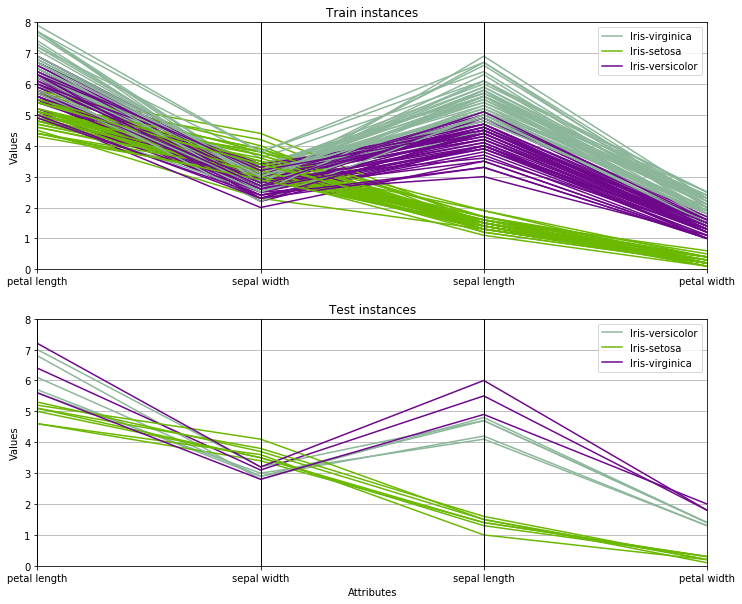

	Continuous attributes: {'petal length', 'sepal width', 'petal width', 'sepal length'}
	Discrete attributes: set()
	Data size: 150
	Train size: 135
	Test size: 15
BUILDING TREE ...
	Attributes: ['sepal length', 'sepal width', 'petal length', 'petal width']
	Generating node: 1
	Split: 1 -- Attribute: sepal length
			Current info gain: 0.012311862111395344 -- Threshould: 4.35
			Current info gain: 0.05031847765847153 -- Threshould: 4.45
			Current info gain: 0.06336408123577142 -- Threshould: 4.55
			Current info gain: 0.09005941630811254 -- Threshould: 4.65
			Current info gain: 0.11760879549032599 -- Threshould: 4.75
			Current info gain: 0.19066457998626385 -- Threshould: 4.85
			Current info gain: 0.18981951110096773 -- Threshould: 4.95
			Current info gain: 0.2686797240845382 -- Threshould: 5.05
			Current info gain: 0.36860124551699314 -- Threshould: 5.15
			Current info gain: 0.39858866901766987 -- Threshould: 5.300000000000001
			Current info gain: 0.5125680391507543 -- Threshoul

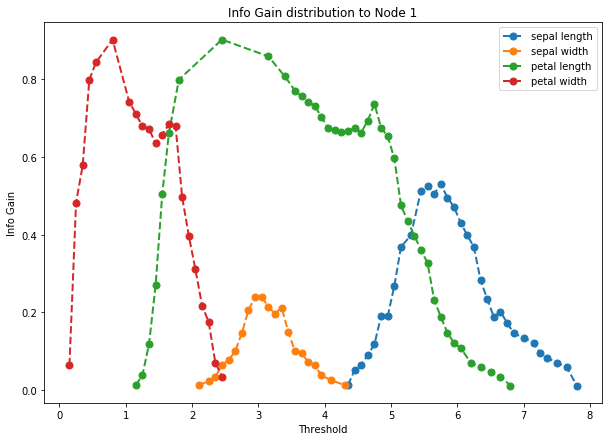

	Attributes: ['sepal length', 'sepal width', 'petal length']
	Generating node: 2
	No split, all data has the same class: [5.0, 3.5, 1.6, 0.6, 'Iris-setosa'] 
	Attributes: ['sepal length', 'sepal width', 'petal length']
	Generating node: 3
	Split: 5 -- Attribute: sepal length
			Current info gain: 7.577419063209412e-06 -- Threshould: 4.95
			Current info gain: 0.009290449901877107 -- Threshould: 5.05
			Current info gain: 0.01702600161139911 -- Threshould: 5.15
			Current info gain: 0.025768531884862944 -- Threshould: 5.300000000000001
			Current info gain: 0.03525252267424128 -- Threshould: 5.45
			Current info gain: 0.09028447152241748 -- Threshould: 5.55
			Current info gain: 0.14152250383537257 -- Threshould: 5.65
			Current info gain: 0.16471052165550382 -- Threshould: 5.75
			Current info gain: 0.13444735889971993 -- Threshould: 5.85
			Current info gain: 0.14183607142009913 -- Threshould: 5.95
			Current info gain: 0.16155382131421903 -- Threshould: 6.05
			Current info gain: 0.1

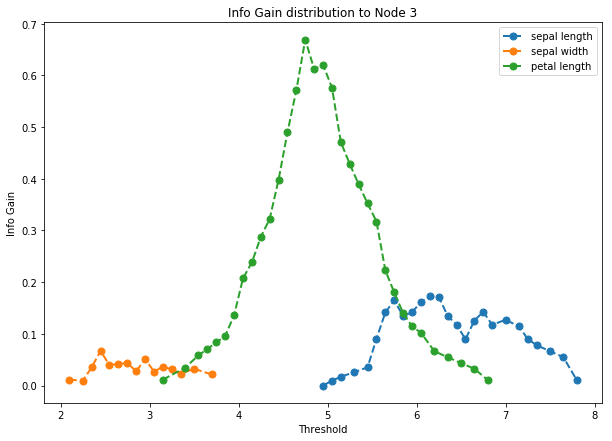

	Attributes: ['sepal length', 'sepal width']
	Generating node: 4
	Split: 8 -- Attribute: sepal length
			Current info gain: 0.11664654619138874 -- Threshould: 4.95
			Current info gain: 0.08627794868318066 -- Threshould: 5.05
			Current info gain: 0.07738702242463724 -- Threshould: 5.15
			Current info gain: 0.0703018015599223 -- Threshould: 5.300000000000001
			Current info gain: 0.06440973033586941 -- Threshould: 5.45
			Current info gain: 0.044309907078130095 -- Threshould: 5.55
			Current info gain: 0.033801642145724786 -- Threshould: 5.65
			Current info gain: 0.025721201256775933 -- Threshould: 5.75
			Current info gain: 0.0206848540135654 -- Threshould: 5.85
			Current info gain: 0.01915447233781678 -- Threshould: 5.95
			Current info gain: 0.014926305051260524 -- Threshould: 6.05
			Current info gain: 0.011152180104657933 -- Threshould: 6.15
			Current info gain: 0.00884375648390412 -- Threshould: 6.25
			Current info gain: 0.0066775056137649 -- Threshould: 6.35
			Current info

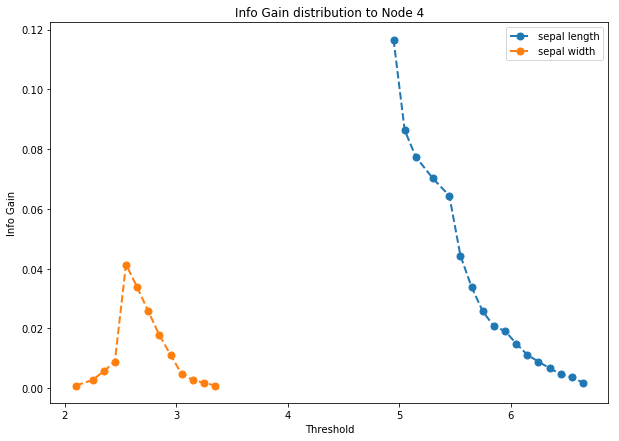

	Attributes: ['sepal width']
	Generating node: 5
	Split: 10 -- Attribute: sepal width
			Current info gain: 1.0 -- Threshould: 2.45

 ---------------------------------------------------------------------------------------------
	Split id: 10
	Best attribute: sepal width
	Best thresoulder: 2.45
	Max gain: 1.0
 ---------------------------------------------------------------------------------------------



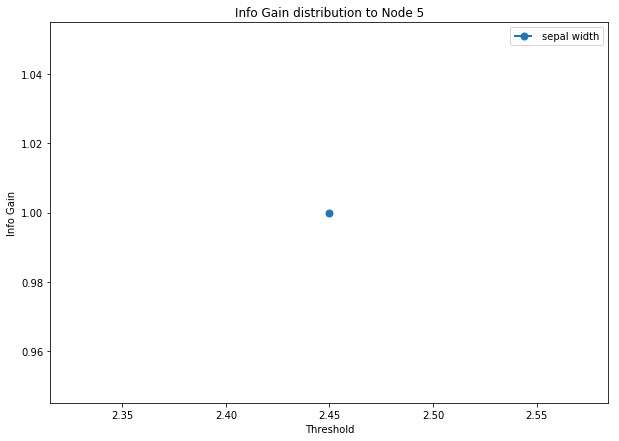

	Attributes: []
	Generating node: 6
	Attributes: []
	Generating node: 7
	Attributes: ['sepal width']
	Generating node: 8
	No split, all data has the same class: [6.7, 3.1, 4.7, 1.5, 'Iris-versicolor'] 
	Attributes: ['sepal length', 'sepal width']
	Generating node: 9
	Split: 11 -- Attribute: sepal length
			Current info gain: 0.0029494570200550574 -- Threshould: 5.75
			Current info gain: 0.012186239015346156 -- Threshould: 5.85
			Current info gain: 0.004437457100055109 -- Threshould: 5.95
			Current info gain: 0.02216870019593159 -- Threshould: 6.05
			Current info gain: 0.013790537850931928 -- Threshould: 6.15
			Current info gain: 0.00797609884399969 -- Threshould: 6.25
			Current info gain: 0.01381880646794742 -- Threshould: 6.35
			Current info gain: 0.005276422287274929 -- Threshould: 6.45
			Current info gain: 0.0008293589303570159 -- Threshould: 6.6
			Current info gain: 0.006790489254413945 -- Threshould: 6.75
			Current info gain: 0.003578664906711715 -- Threshould: 6.85
			C

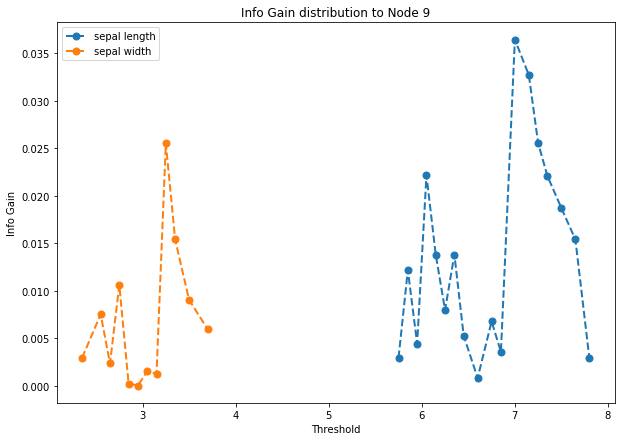

	Attributes: ['sepal width']
	Generating node: 10
	Split: 13 -- Attribute: sepal width
			Current info gain: 0.0048817067326131225 -- Threshould: 2.35
			Current info gain: 0.004702932061658727 -- Threshould: 2.55
			Current info gain: 0.0018856115959436925 -- Threshould: 2.6500000000000004
			Current info gain: 0.007575656277166831 -- Threshould: 2.75
			Current info gain: 0.0 -- Threshould: 2.8499999999999996
			Current info gain: 0.0002648192863820009 -- Threshould: 2.95
			Current info gain: 0.0011134661909409926 -- Threshould: 3.05
			Current info gain: 0.0014334148875970731 -- Threshould: 3.1500000000000004
			Current info gain: 0.025850761940059863 -- Threshould: 3.25
			Current info gain: 0.009899465759834691 -- Threshould: 3.3499999999999996

 ---------------------------------------------------------------------------------------------
	Split id: 13
	Best attribute: sepal width
	Best thresoulder: 3.25
	Max gain: 0.025850761940059863
 -------------------------------------------

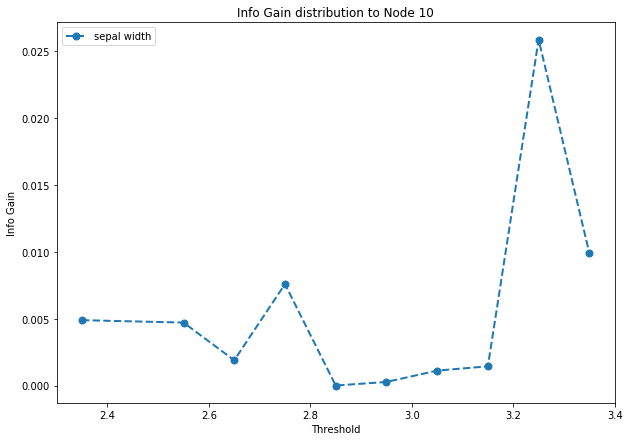

	Attributes: []
	Generating node: 11
	Attributes: []
	Generating node: 12
	Attributes: ['sepal width']
	Generating node: 13
	No split, all data has the same class: [7.9, 3.8, 6.4, 2.0, 'Iris-virginica'] 


PRINTING TREE ...
(Node: 1 - SrcSplit: 4) petal width <= 0.8 : Iris-setosa  
(Node: 1 - SrcSplit: 4) petal width > 0.8 : 
	(Node: 3 - SrcSplit: 7) petal length <= 4.75 : 
		(Node: 4 - SrcSplit: 8) sepal length <= 4.95 : 
			(Node: 5 - SrcSplit: 10) sepal width <= 2.45 : Iris-versicolor  
			(Node: 5 - SrcSplit: 10) sepal width > 2.45 : Iris-virginica  
		(Node: 4 - SrcSplit: 8) sepal length > 4.95 : Iris-versicolor  
	(Node: 3 - SrcSplit: 7) petal length > 4.75 : 
		(Node: 9 - SrcSplit: 11) sepal length <= 7.0 : 
			(Node: 10 - SrcSplit: 13) sepal width <= 3.25 : Iris-virginica  
			(Node: 10 - SrcSplit: 13) sepal width > 3.25 : Iris-virginica  
		(Node: 9 - SrcSplit: 11) sepal length > 7.0 : Iris-virginica  




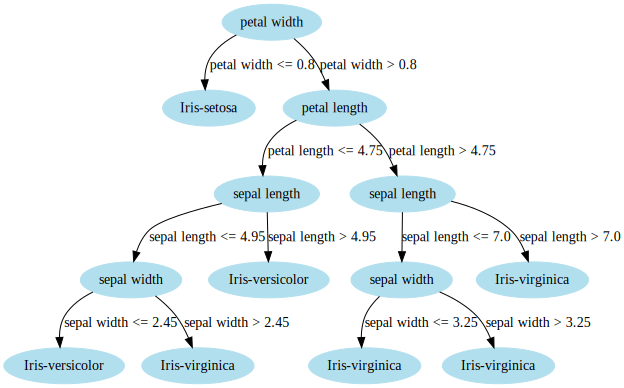

CLASSIFICATION RESULT ...
	Instance: {'sepal length': 4.6, 'sepal width': 3.4, 'petal length': 1.4, 'petal width': 0.3, 'outcome': 'Iris-setosa'} -- Classification Result: Iris-setosa
		petal width 0.3 <= 0.8
	Instance: {'sepal length': 5.3, 'sepal width': 3.7, 'petal length': 1.5, 'petal width': 0.2, 'outcome': 'Iris-setosa'} -- Classification Result: Iris-setosa
		petal width 0.2 <= 0.8
	Instance: {'sepal length': 5.0, 'sepal width': 3.5, 'petal length': 1.3, 'petal width': 0.3, 'outcome': 'Iris-setosa'} -- Classification Result: Iris-setosa
		petal width 0.3 <= 0.8
	Instance: {'sepal length': 5.1, 'sepal width': 3.5, 'petal length': 1.4, 'petal width': 0.3, 'outcome': 'Iris-setosa'} -- Classification Result: Iris-setosa
		petal width 0.3 <= 0.8
	Instance: {'sepal length': 5.1, 'sepal width': 3.8, 'petal length': 1.6, 'petal width': 0.2, 'outcome': 'Iris-setosa'} -- Classification Result: Iris-setosa
		petal width 0.2 <= 0.8
	Instance: {'sepal length': 5.2, 'sepal width': 4.1, 'petal

In [2]:
import pdb
#from c45 import C45

c1 = C45("../data/iris/iris.data", "../data/iris/iris.names")
#c1 = C45("../data/diabetes.data", "../data/diabetes.names")

c1.fetchData()
c1.preprocessData()
c1.generateTree()
c1.printTree()
c1.classify(c1.tree)


## Low training error rates, don't means a good model!
<center><img src="overfitting.png" height='600' width='600' > https://arxiv.org/pdf/1906.01998.pdf </img></center>
